In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/va_ev_registrations_public.csv')

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2002-08-20,3.0
2002-09-18,5.0
2003-08-08,5.0
2004-08-25,5.0
2005-04-21,5.0
...,...
2021-12-28,113.0
2021-12-29,119.0
2021-12-30,115.0


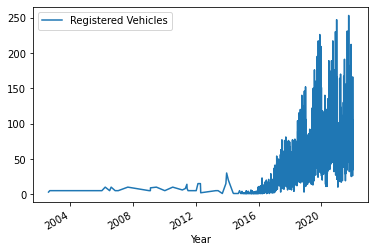

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

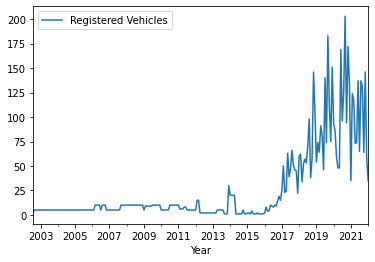

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(-1.2453430718766254,
 0.6537926602124564,
 15,
 218,
 {'1%': -3.460707667106296,
  '5%': -2.874891213486339,
  '10%': -2.573885987711472},
 1838.6585471136777)

## Modeling

In [9]:
# Splitting Training and Testing data; using after 2019 as test

train = df[:'2020-12']
test = df['2021':]
combined = df
test

,Registered Vehicles
Year,
2021-01-31,35.0
2021-02-28,124.0
2021-03-31,117.0
2021-04-30,73.0
2021-05-31,74.0
2021-06-30,137.0
2021-07-31,65.0
2021-08-31,137.0
2021-09-30,131.0


In [10]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2290.883, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2006.276, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2144.425, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1942.107, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1909.296, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1910.510, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1896.239, Time=0.16 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1887.970, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1888.539, Time=0.31 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=1883.926, Time=0.26 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1885.493, Time=0.14 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=1875.648, Time=0.41 sec
 ARIMA(6,0,2)(0,0,0)[0]             : AIC=1

### The best model is :  ARIMA (6, 0, 1) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2060      6.943      0.030      0.976     -13.402      13.814
ar.L2          0.2736      1.711      0.160      0.873      -3.080       3.627
ar.L3          0.4269      1.817      0.235      0.814      -3.135       3.989
ar.L4         -0.0911      2.863     -0.032      0.975      -5.702       5.520
ar.L5          0.2252      0.766      0.294      0.769      -1.276       1.727
ar.L6          0.0015      1.602      0.001      0.999      -3.139       3.142
ma.L1          0.0415      6.952      0.006      0.995     -13.584      13.667
sigma2       294.7258     12.304     23.955      0.000     270.611     318.840


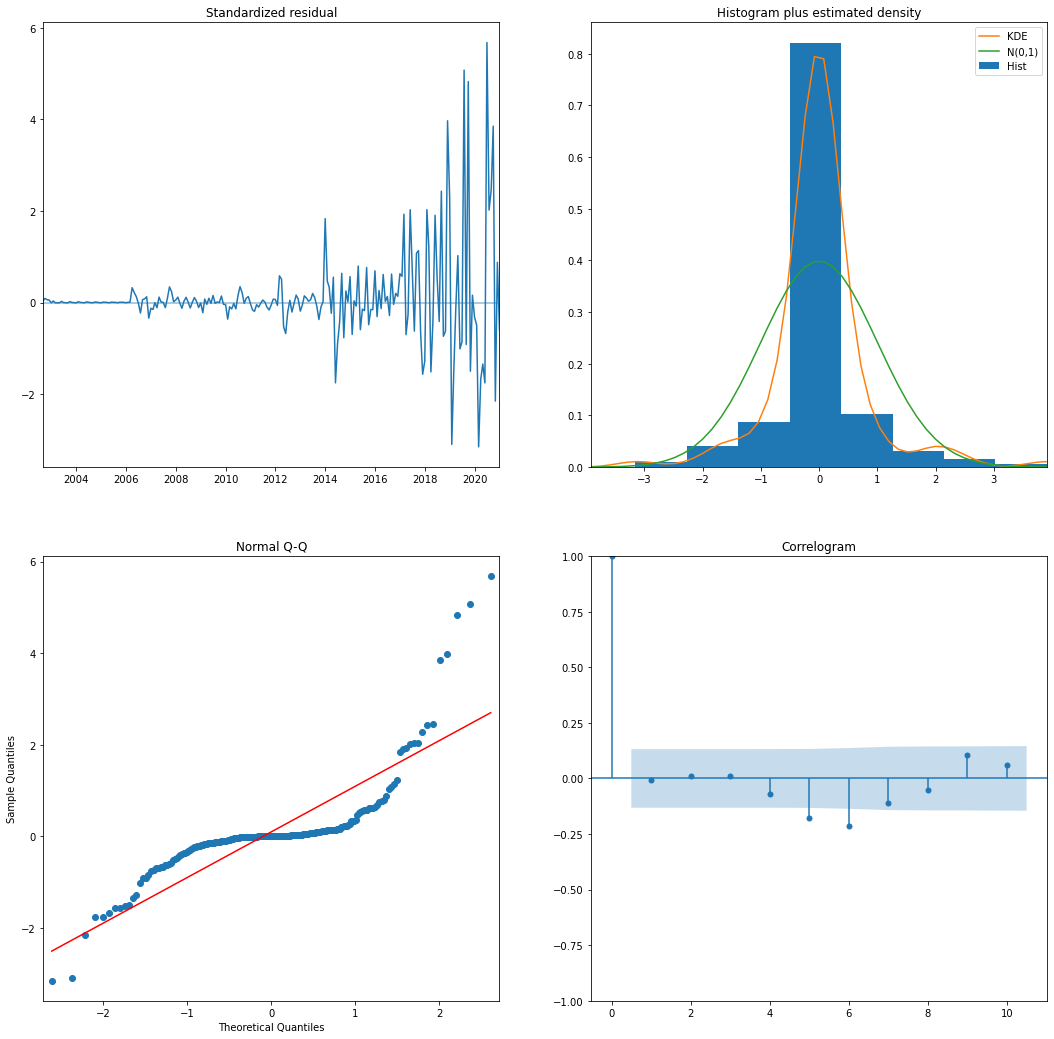

In [11]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(6,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [12]:
pred = output.get_prediction(start=pd.to_datetime('2021-01-01'), end=pd.to_datetime('2022-01-01'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2021-01-31,89.908733,157.204415
2021-02-28,138.216608,207.542657
2021-03-31,96.081539,168.766681
2021-04-30,113.031187,194.951045
2021-05-31,119.314267,202.549649
2021-06-30,98.680027,189.500839
2021-07-31,118.756788,214.251459
2021-08-31,109.265374,207.684522
2021-09-30,107.582542,212.273056
2021-10-31,116.728199,224.728124


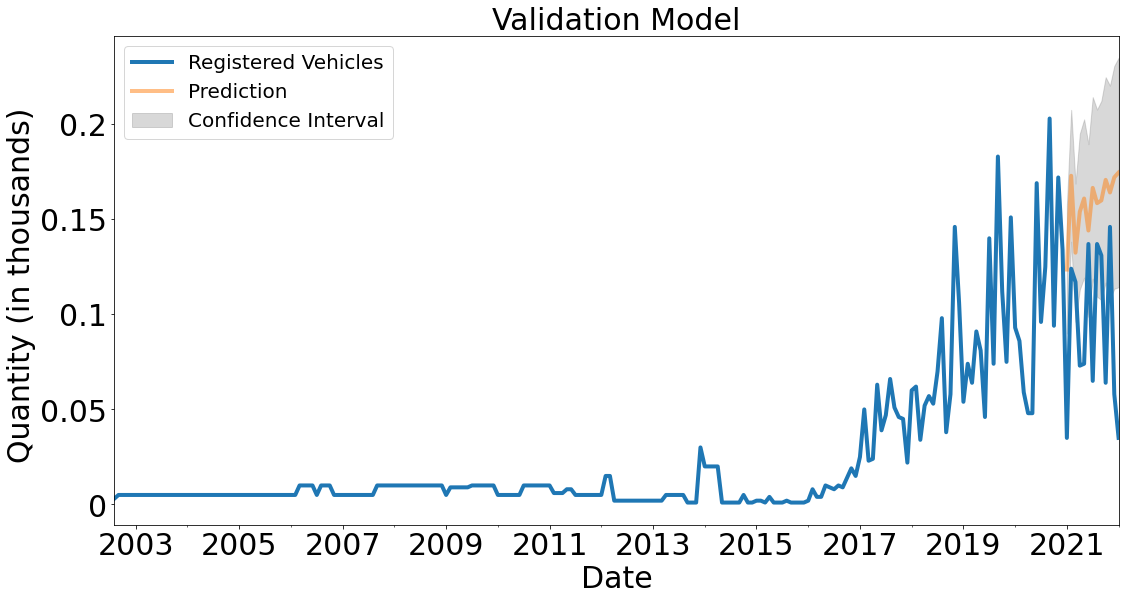

In [13]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()